# Bike Sharing using Multiple Linear Regression

In [1]:
# importing the libraries
import warnings
warnings.filterwarnings('ignore')

# Libraries for data cleaning and visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# importing libraries from sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# importing statsmodels library
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:

# loading the data into df1 dataframe and viewing the top 5 columns
df1 = pd.read_csv('../input/boom-bikes-linear-regression/day.csv')
df1.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# looking at the shape of the data
df1.shape

(730, 16)

In [4]:
# looking at the various aspects of the data
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
# looking at the statistical aspects of the data
df1.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [6]:
# The variable instant is just a record index and not useful for prediction, Hence dropped
df1 = df1.drop('instant',axis=1)
# The variable atemp is just a derivative of temp variable(inferred from data dictionary) and is highly correlated, Hence dropped
df1 = df1.drop('atemp',axis=1)
# The variable dteday is not useful since we have year and month variables separately, Hence dropped
df1 = df1.drop('dteday',axis=1)
# The variables casual and registered are subsets of cnt(target variable), Hence they are highly correlated and thus dropped
df1 = df1.drop(['casual','registered'],axis=1)

In [7]:
# looking at the data after removing two variables
df1.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801


### As mentioned in the data dictionary a lot of the variables need to be converted from numerical to categorical before we can proceed further.

Many of the numerical variables are representations of categorical data, they have to be convereted to categorical data for better readability of the model. Since we are going to use "one-hot encoding", this process will not affect our model.

In [8]:
# season : season (1:spring, 2:summer, 3:fall, 4:winter)
# Mapping the season names accordingly in the data
df1['season'] = df1['season'].map({1:"spring",2:"summer",3:"fall",4:"winter"})

# mnth : month ( 1 to 12)
# Mapping the month names accordingly in the data
df1['mnth'] = df1['mnth'].map({1: "jan",2: "feb",3: "mar",4: "apr",5: "may",6: "jun",7: "jul",8: "aug",9: "sep",10: "oct" ,11: "nov" ,12: "dec"})

# weekday : day of the week
# The weekdays are mapped with the numbers from ( 0:"sunday"------6:"saturday")
df1['weekday'] = df1['weekday'].map({0: "sun",1: "mon",2: "tue",3: "wed",4: "thu",5: "fri",6: "sat"})

# weathersit -- 1:"clear",2:"cloudy",3:"light_rain",4:"heavy_rain"
df1['weathersit'] = df1['weathersit'].map({1:"clear",2:"cloudy",3:"light_rain",4:"heavy_rain"})

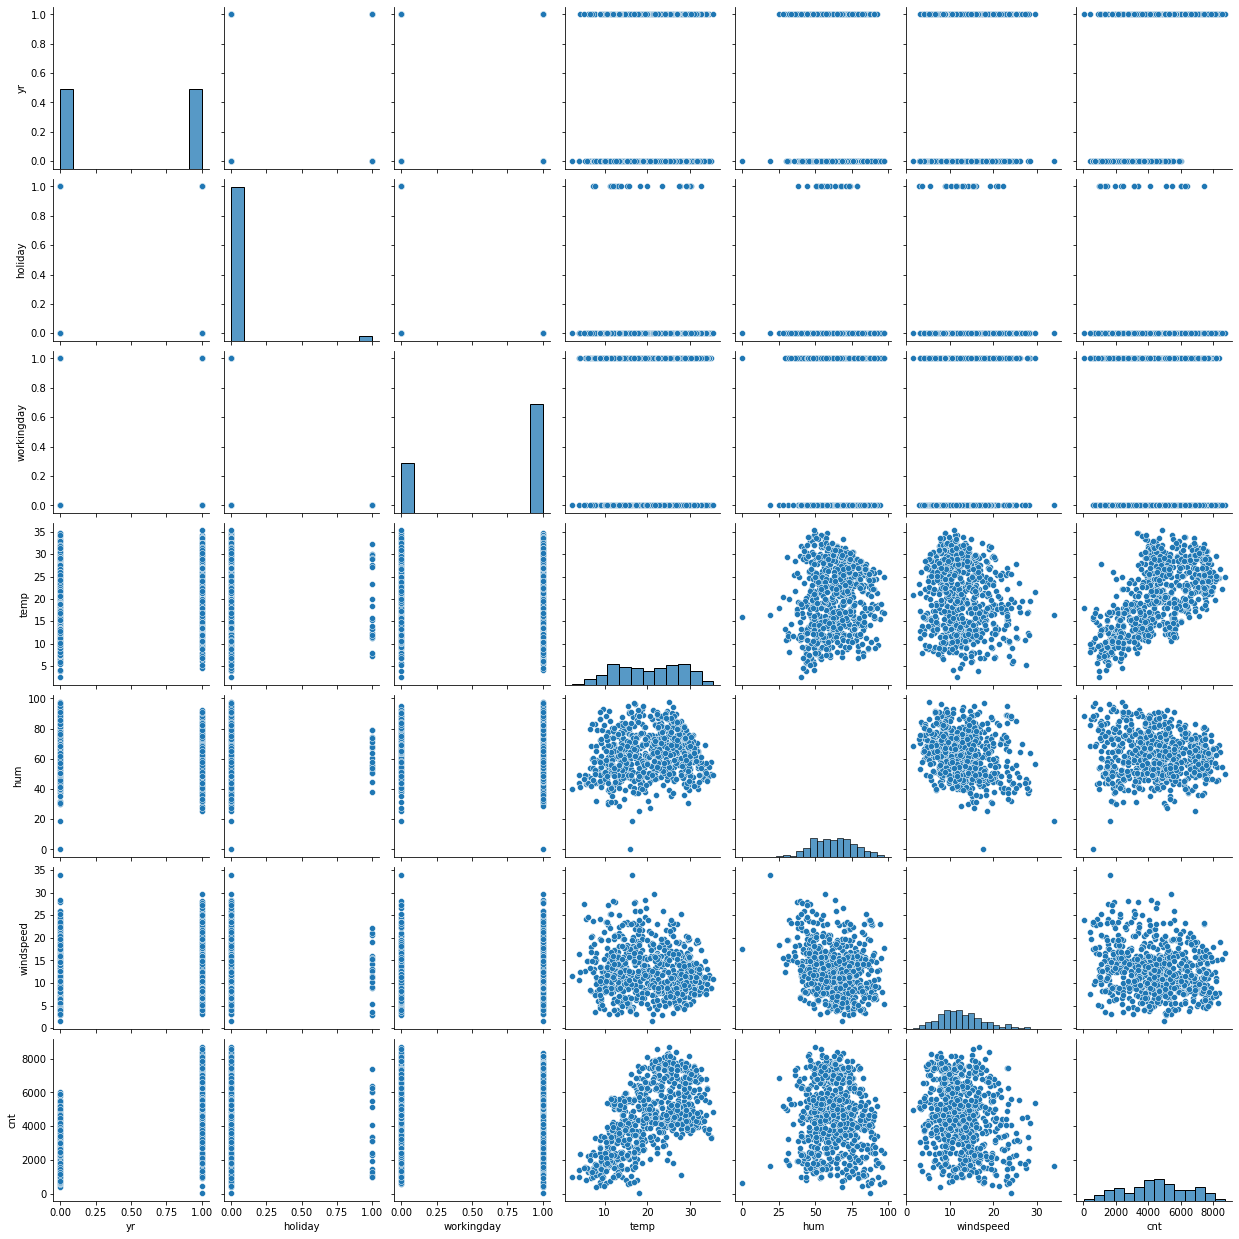

In [9]:
# Lets plot a pairplot for all the variables and see the relations
sns.pairplot(df1)
plt.show()

- There are only a few variables that show some relationship with the target variable

<AxesSubplot:>

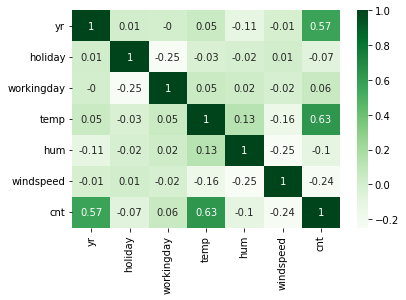

In [10]:
# Let us see the correlation between variables
correlation = round(df1.corr(),2)
sns.heatmap(correlation,cmap='Greens',annot=True)

- **temp** has the highest correlation with the target variable (0.63)

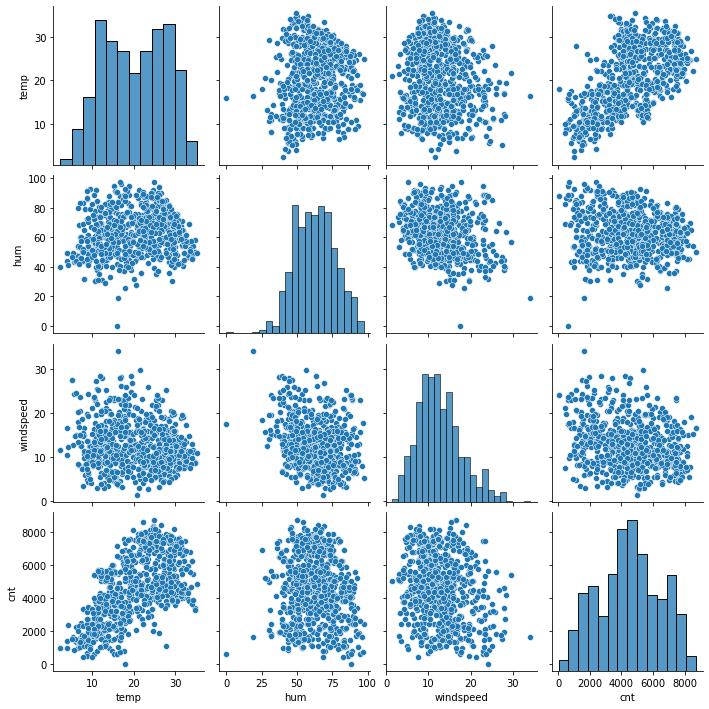

In [11]:
# Let the see how the important variables are related to each other by a pairplot
pp_num_var = ['temp','hum','windspeed','cnt']
sns.pairplot(df1[pp_num_var])
plt.show()

- From the pairplot we can see that **temp** is the variable that has highest correlation with target variable

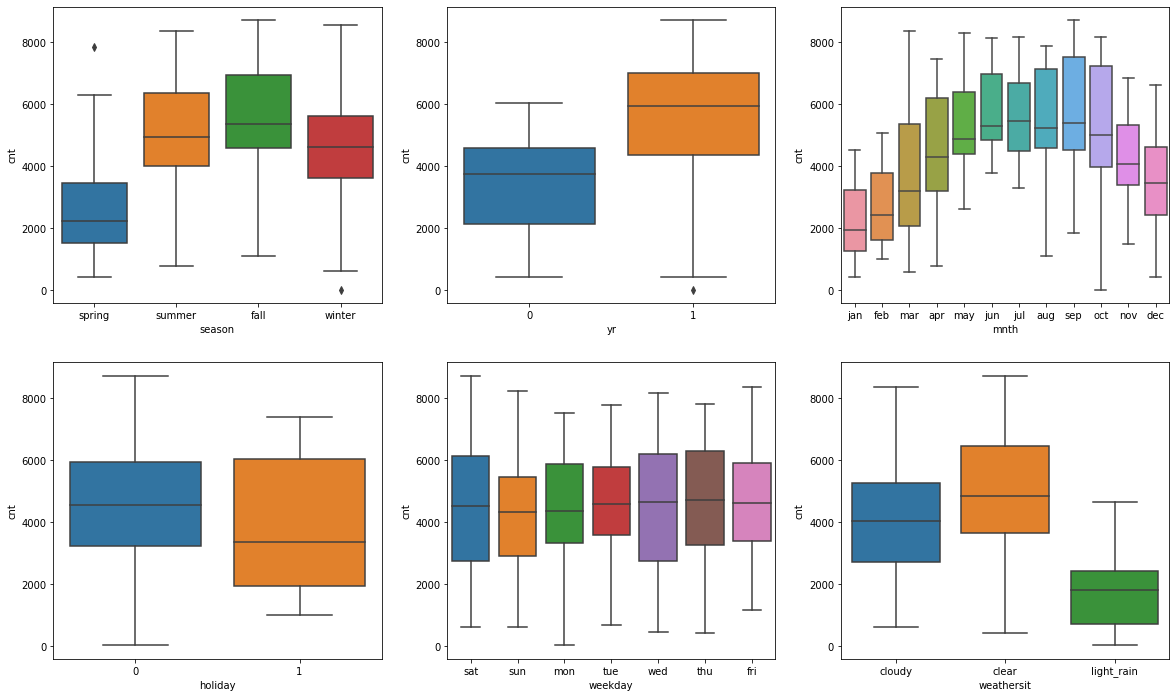

In [12]:
# Let us plot boxplots for different categorical variables with target variable on the Y-axis
vars_cat = ['season','yr','mnth','holiday','weekday','weathersit']
plt.figure(figsize=(20, 12))
for i in enumerate(vars_cat):
    plt.subplot(2,3,i[0]+1)
    sns.boxplot(data=df1, x=i[1], y='cnt')
plt.show()

## Creating Dummy variables for all the categorical variables

In [13]:
# Creating dummy variables for the categories ('season','mnth','weekday','weathersit')
df1 = pd.get_dummies(data=df1,columns=["season","mnth","weekday"],drop_first=True)
df1 = pd.get_dummies(data=df1,columns=["weathersit"])

- Dropping the first columns as (p-1) dummies can explain p categories.
- In weathersit first column was not dropped so as to not lose the info about any weather situation.

In [14]:
# Print columns after creating dummies
df1.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'season_spring', 'season_summer', 'season_winter', 'mnth_aug',
       'mnth_dec', 'mnth_feb', 'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar',
       'mnth_may', 'mnth_nov', 'mnth_oct', 'mnth_sep', 'weekday_mon',
       'weekday_sat', 'weekday_sun', 'weekday_thu', 'weekday_tue',
       'weekday_wed', 'weathersit_clear', 'weathersit_cloudy',
       'weathersit_light_rain'],
      dtype='object')

In [15]:
# Looking at the data frame after creation of dummy variables
df1.head(2)

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_light_rain
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,1,0,0,0,0,1,0


## Model Building
Now that the data is cleaned and the dummy variables are created, let's start building the model

In [16]:
# Checking shape before splitting
df1.shape

(730, 30)

In [17]:
# Split the train_data into X and y sets
y = df1.pop('cnt')
X = df1

In [18]:
# Splitting the data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.7,random_state=100)
# Here we split 70% into training data and 30% into test data 

In [19]:
# Printing the shape of X_train, X_test
print(X_train.shape)
print(X_test.shape)

(510, 29)
(220, 29)


## Scaling
Let us scale the numerical variables by using MinMaxScaler

In [20]:
# Using MinMaxScaler for scaling 
scaler = MinMaxScaler()
num_vars = ['temp','hum','windspeed']
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

In [21]:
# Looking the X_train data after scaling
X_train.head(2)

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_aug,...,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_clear,weathersit_cloudy,weathersit_light_rain
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
426,1,0,0,0.442393,0.640189,0.255342,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


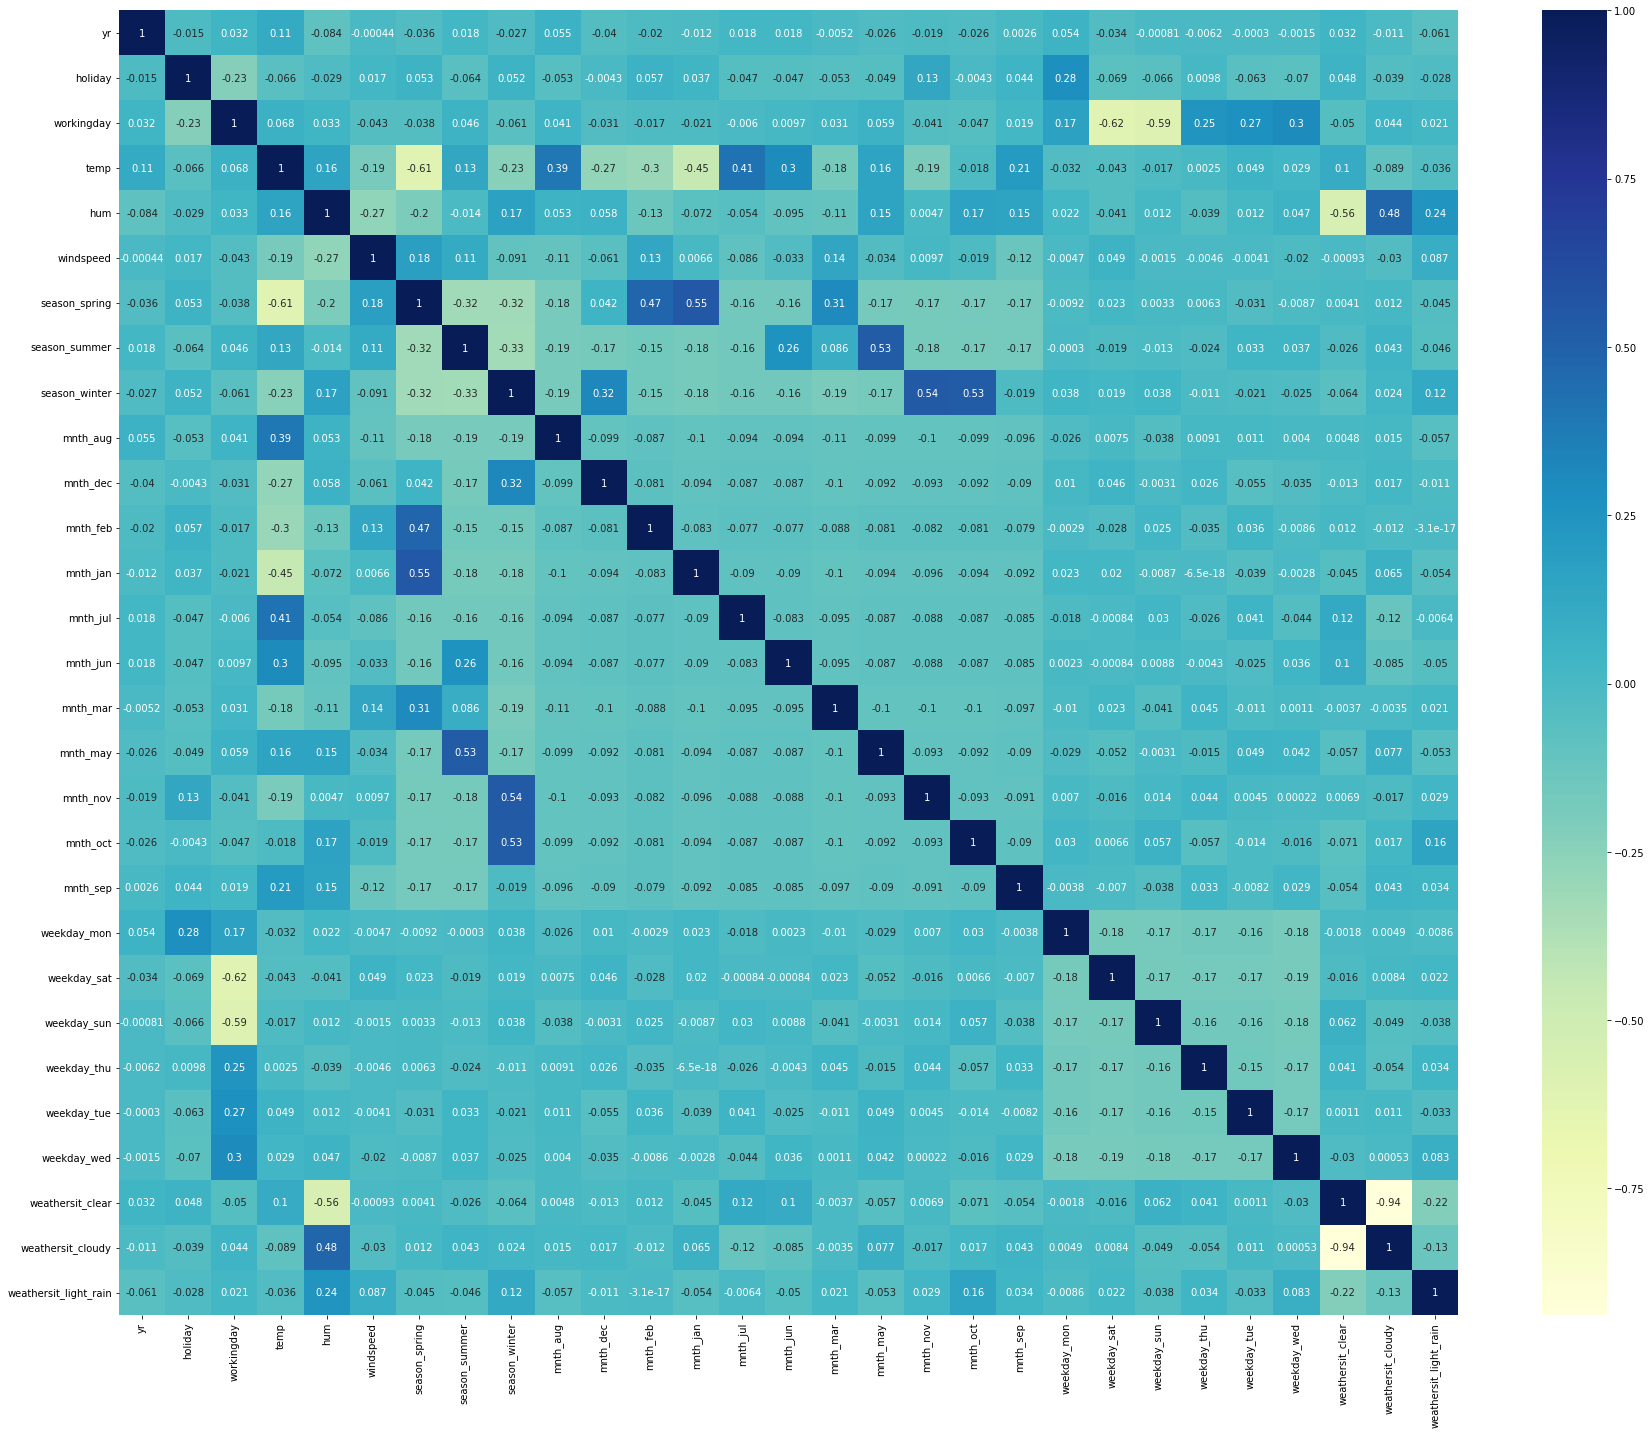

In [22]:
# plotting a heatmap to see the correlation between the variables after scaling
plt.figure(figsize=(30,24))
sns.heatmap(X_train.corr(),cmap='YlGnBu',annot=True)
plt.show()

# Model Building Process



### RFE
- Recursive feature elimination
- RFE is available in LinearRegression Module in sklearn library
- Using RFE to find the top 10 significant variables

In [23]:
# Running rfe from sklearn 
lr = LinearRegression()
lr.fit(X_train,y_train)
# selecting the top 10 variables after RFE
rfe = RFE(lr,n_features_to_select = 10)
rfe = rfe.fit(X_train,y_train)

In [24]:
# Printing the variable ranking after RFE 
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 6),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', False, 2),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_aug', False, 13),
 ('mnth_dec', False, 9),
 ('mnth_feb', False, 10),
 ('mnth_jan', False, 7),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 20),
 ('mnth_mar', False, 19),
 ('mnth_may', False, 11),
 ('mnth_nov', False, 8),
 ('mnth_oct', False, 16),
 ('mnth_sep', True, 1),
 ('weekday_mon', False, 14),
 ('weekday_sat', False, 5),
 ('weekday_sun', False, 12),
 ('weekday_thu', False, 17),
 ('weekday_tue', False, 15),
 ('weekday_wed', False, 18),
 ('weathersit_clear', False, 3),
 ('weathersit_cloudy', False, 4),
 ('weathersit_light_rain', True, 1)]

In [25]:
# Looking at the columns that are considered by RFE
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_winter', 'mnth_jul', 'mnth_sep', 'weathersit_light_rain'],
      dtype='object')

In [26]:
# Looking at the columns tha are rejected by RFE
X_train.columns[~rfe.support_]

Index(['workingday', 'season_spring', 'mnth_aug', 'mnth_dec', 'mnth_feb',
       'mnth_jan', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov', 'mnth_oct',
       'weekday_mon', 'weekday_sat', 'weekday_sun', 'weekday_thu',
       'weekday_tue', 'weekday_wed', 'weathersit_clear', 'weathersit_cloudy'],
      dtype='object')

In [27]:
# Function to build a model using statsmodel api - Takes the columns to be selected for model as a parameter
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [28]:
# Function to calculate VIFs and print them -Takes the columns for which VIF to be calcualted as a parameter
def get_vif(cols):
    df = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [29]:
# Taking 10 columns supported by RFE for regression
X_train_rfe = X_train[['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_winter', 'mnth_jul', 'mnth_sep', 'weathersit_light_rain']]

# Model_1
Let us now build an LR model using the significant variables

In [30]:
# Selected columns for Model 1 - all columns selected by RFE
cols = ['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_summer',
       'season_winter', 'mnth_jul', 'mnth_sep', 'weathersit_light_rain']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     247.6
Date:                Mon, 06 Jun 2022   Prob (F-statistic):          2.79e-186
Time:                        13:36:51   Log-Likelihood:                -4131.6
No. Observations:                 510   AIC:                             8285.
Df Residuals:                     499   BIC:                             8332.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2353.21

- Model_1 has 10 variables with neglegent p-values and an R2 score of 0.83
- By plotting VIF of the variables we get the variable 'hum' having high VIF, so we remove 'hum' and build another model

# Model_2
Building an updated model where the variable 'hum' is removed for having high VIF

In [31]:
# Building a new model after removing 'hum'
cols = ['yr', 'holiday', 'temp', 'windspeed', 'season_summer',
       'season_winter', 'mnth_jul', 'mnth_sep', 'weathersit_light_rain']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     229.0
Date:                Mon, 06 Jun 2022   Prob (F-statistic):          4.42e-171
Time:                        13:36:51   Log-Likelihood:                -4170.3
No. Observations:                 510   AIC:                             8361.
Df Residuals:                     500   BIC:                             8403.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   752.13

- Model_2 has 8 variables with neglegent p-values and 1 variable 'mnth_jul' with high p-value and an R2 score of 0.805
- By plotting VIF of the variables we get the variable 'temp' having a VIF of 4.96, but the coefficient value of temp is high, so let's remove 'mnth_jul' variable that has higher p-value and see if the VIF of temp reduces.

# Model_3 
Building a new LR model where 'mnth_jul' is removed as it has high P-value, making it insignificant

In [32]:
# Removed mnth_jul as it has high p_value and build a new model
cols = ['yr', 'holiday', 'temp', 'windspeed', 'season_summer',
       'season_winter', 'mnth_sep', 'weathersit_light_rain']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     256.6
Date:                Mon, 06 Jun 2022   Prob (F-statistic):          9.22e-172
Time:                        13:36:52   Log-Likelihood:                -4171.6
No. Observations:                 510   AIC:                             8361.
Df Residuals:                     501   BIC:                             8399.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   782.79

- Model_3 has 8 variables with neglegent p-values and an R2 score of 0.804 and Adjusted R2_score of 0.801 which is intact after removal of 'mnth_jul' variable.
- By plotting VIF of the variables we get the variable 'temp' having a VIF of 3.63 and all other variables with lower VIF's.

- So we can consider these variables to be significant and use them for building a model 
- ['yr', 'holiday', 'temp', 'windspeed', 'season_summer','season_winter', 'mnth_sep', 'weathersit_light_rain']

## Building a Linear Regression model using Sklearn for the final variables
We have built model_3 with statsmodels.api with sig_vars, Now we will build a model using sklearn with the same significant variables

In [33]:
# Store the variables we found significant from model_3 into sig_vars
sig_vars = ['yr', 'holiday', 'temp', 'windspeed', 'season_summer','season_winter', 'mnth_sep', 'weathersit_light_rain'] 

In [34]:
# Make X_train_reg by using only significant variables
X_train_reg = X_train[sig_vars]

In [35]:
# Initiate LinearRegression() 
reg = LinearRegression()
# fit the model with X_train_reg,y_train
reg.fit(X_train_reg,y_train)

LinearRegression()

In [36]:
# Check the intercept value
reg.intercept_

782.7922074962935

In [37]:
# Check the coefficients of the model
reg.coef_

array([ 2029.01045353,  -753.31288775,  4938.90132318, -1264.48627207,
         705.35674961,  1095.77065709,   777.92919084, -2203.34039743])

In [38]:
# Check the y_train_pred values to see how the model is performing
y_train_pred = reg.predict(X_train_reg)

<AxesSubplot:ylabel='cnt'>

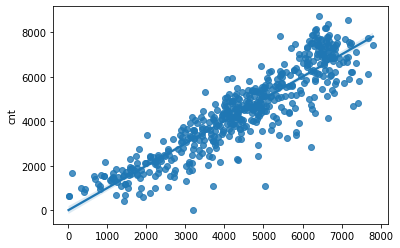

In [39]:
# Plot a regplot between y_train and y_train_pred to see linear pattern
sns.regplot(y_train_pred,y_train)

- In the above plot we see the linear distribution of y_train and a regression line made by y_train_pred

In [40]:
# Checking the r2_score of the train data
R2_train = r2_score(y_train,y_train_pred)
R2_train

0.8038032148021996

In [41]:
# Calculating the Adjusted R2 value
n = len(X_train.index)
p = len(reg.coef_)
Adj_R2_train = 1-(1-R2_train)*(n-1)/(n-p-1)
Adj_R2_train

0.80067033200463

# Assumptions of Linear Regression

## Residual Analysis
Let us check the residual analysis of train data to see if the residuals are Normally distributed

In [42]:
# Finding out error terms by subtracting y_train_pred from y_train and saving it to res
res = y_train - y_train_pred

<AxesSubplot:xlabel='cnt', ylabel='Density'>

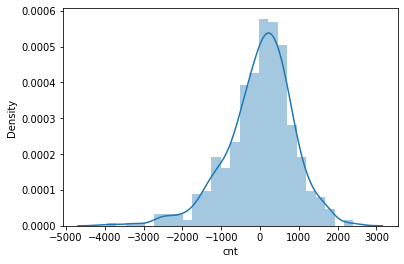

In [43]:
# Checking the error terms 
sns.distplot(res)

- The error terms/residuals are Normally distributed, which is an assumption of Linear Regression

## Homoscedasticity

<AxesSubplot:ylabel='cnt'>

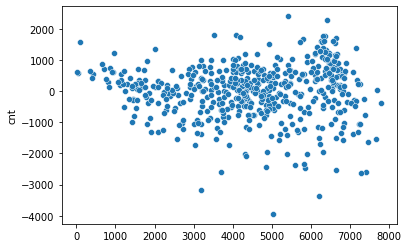

In [44]:
# Plotting a scatter plot for residuals and y predicted values 
sns.scatterplot(y_train_pred,res)

- The error term here is not following any common patterns and is completely random in nature.

## Error term Normal - Distribution (Q-Q plot)

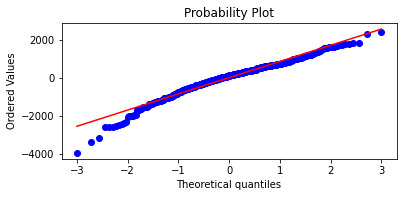

In [45]:
# Plotting a Q-Q plot for the residuals
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(res, plot=ax, fit=True)

- From the above plot, we can makeout that the error terms are normally distributed.

## Independence of residuals
The independence of the residuals can be calculated by the Durbin-Watson test 

In [46]:
# Performing a Durbin_Watson test on train data and its prediction
from statsmodels.stats.stattools import durbin_watson
DWT = durbin_watson((y_train_pred-y_train))
DWT

2.020535343868037

- A score of 2.02 in Durbin_watson test shows that the residuals are independent and there is no auto collinearity.

# Making predictions on test data
Now that we have made predictions on the train data, Now lets make predictions on the test data

In [47]:
# Scaling of the num_vars in test data using scaler.transform
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [48]:
# Creating X_test_reg out of the significant variables 'sig_vars'
X_test_reg = X_test[sig_vars]

In [49]:
# Predicting the values of y_pred for X_test_reg data
y_pred = reg.predict(X_test_reg)

<AxesSubplot:xlabel='cnt'>

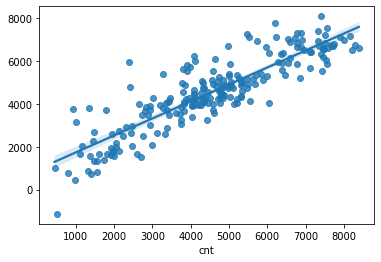

In [50]:
# Plotting a regplot between y_test and y_pred
sns.regplot(y_test,y_pred)

- In the above plot we can see the y_test is linearly distributed and the best-fit line by y_pred

In [51]:
# Finding the r2_score of test data
R2_test = r2_score(y_test,y_pred)
R2_test 

0.77207319495548

In [52]:
# Calculating the Adjusted R2 value
n = len(X_test.index)
p = len(reg.coef_)
Adj_R2_test = 1-(1-R2_test)*(n-1)/(n-p-1)
Adj_R2_test

0.7634314203566356

### The R2 and the adjusted R2 of 0.77 and 0.76 respectively in the test data shows that the model is doing well.

## Important variables and their Coefficients
Let us look the important variables and the magnitudes with which they influence the demand

In [53]:
# Creating a new dataframe 'coefficients' that has the significant variables and the their respective coefficeints
coefficients = pd.DataFrame({"variables": sig_vars, "coefficients": reg.coef_})
coefficients.sort_values(by = 'coefficients',ascending = False)

,variables,coefficients
2,temp,4938.901323
0,yr,2029.010454
5,season_winter,1095.770657
6,mnth_sep,777.929191
4,season_summer,705.356750
1,holiday,-753.312888
3,windspeed,-1264.486272
7,weathersit_light_rain,-2203.340397


## The LinearRegression equation is
**Y = 782.79  +  2029.01(yr)  - 753.31(holiday)  +  4938.9(temp)  -  1264.48(windspeed)  +  705.35(season_summer)  +  1095.77(season_winter)  +  777.92(mnth_sep)  -  2203.34(weathersit_light_rain) **

From the above variables we can see there are a few that contribute positively towards the demand and some variables that negatively influence the demand

Variables that contribute positively and their coefficients    
- temp --> 4938.90
- yr   --> 2029.01
- season_winter --> 1095.77
- mnth_sep --> 777.92
- season_summer --> 705.35

Variables that contribute negatively and their coefficients    
- weathersit_light_rain --> -2203.34
- windspeeed --> -1264.48
- holiday --> -753.31

### The company can plan to increase the availability of bikes during peak demand periods and try to roll-out offers and plan maintenance activities during lean demand periods as per the variables and their coefficients.